In [1]:
import os

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bokeh.io import output_notebook
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from JapanHorseRaceAnalytics.utilities.base import get_spark_session, read_hive_table
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

# Set pandas display options
pd.set_option("display.max_rows", 1050)
pd.set_option("display.max_columns", 200)

# Set seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
random_state = 42

output_notebook()

Loading BokehJS ...

In [2]:
spark = get_spark_session()

24/03/04 08:21:22 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/03/04 08:21:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/03/04 08:21:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
data = read_hive_table(
    table_name="features_20240217_v1",
    schema="jhra_curated",
    spark_session=spark,
    use_cache=False,
    parse_dates=["meta_発走日時"],
)

logger.info(f"Original data shape: {data.shape}")

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# drop from data where meta_int_race_horses_異常区分 != '0'
data = data[(data["meta_int_race_horses_異常区分"] == "0")]

# keep only horses that have 3 races
data = data[
    (data["num_一走前着順"].notnull())
    & (data["num_二走前着順"].notnull())
    & (data["num_三走前着順"].notnull())
]

logger.info(f"Data shape after filtering: {data.shape}")

data.reset_index(drop=True, inplace=True)
data.head()

{"event": "Read from hive jhra_curated.features_20240217_v1", "level": "info", "timestamp": "2024-03-03T23:21:24.050524Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
24/03/04 08:21:24 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/03/04 08:21:24 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/03/04 08:21:25 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
{"event": "Write to parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240217_v1.snappy.parquet", "level": "info", "timestamp": "2024-03-03T23:21:26.510146Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
24/03/04 08:21:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_2024021

,meta_レースキー,meta_馬番,meta_着順,meta_発走日時,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_races_レースキー,meta_int_races_発走日時,meta_int_races_場コード,cat_四半期,cat_距離,cat_事前_馬場状態コード,num_事前_馬場差,cat_実績_馬場状態コード,num_実績_馬場差,cat_レース条件_記号,cat_レース条件_条件,cat_レース条件_重量,cat_レース条件_トラック情報_内外,cat_レース条件_トラック情報_右左,cat_レース条件_種別,cat_レース条件_グレード,cat_トラック種別,cat_馬場状態内,cat_馬場状態中,cat_馬場状態外,num_直線馬場差最内,num_直線馬場差内,num_直線馬場差中,num_直線馬場差外,num_直線馬場差大外,cat_芝種類,num_草丈,cat_転圧,cat_凍結防止剤,num_中間降水量,meta_int_race_horses_レースキー,meta_int_race_horses_馬番,meta_int_race_horses_血統登録番号,meta_int_race_horses_発走日時,meta_int_race_horses_異常区分,num_事前ＩＤＭ,cat_事前脚質,num_事前単勝オッズ,num_事前複勝オッズ,cat_事前馬体,cat_事前気配コード,cat_事前上昇度,cat_事前クラスコード,num_事前テン指数,num_事前ペース指数,num_事前上がり指数,num_負担重量,num_馬体重,num_馬体重増減,cat_性別,cat_トラック種別瞬発戦好走馬,cat_トラック種別消耗戦好走馬,num_一走前不利,num_二走前不利,num_三走前不利,num_一走前着順,num_二走前着順,num_三走前着順,num_四走前着順,num_五走前着順,num_六走前着順,num_1走前上昇度,num_2走前上昇度,num_3走前上昇度,num_4走前上昇度,num_5走前上昇度,num_騎手指数,num_情報指数,num_オッズ指数,num_パドック指数,num_総合指数,cat_馬具変更情報,cat_脚元情報,cat_見習い区分,cat_オッズ印,cat_パドック印,cat_直前総合印,cat_距離適性,num_ローテーション,num_基準オッズ,num_基準人気順位,num_基準複勝オッズ,num_基準複勝人気順位,num_特定情報◎,num_特定情報○,num_特定情報▲,num_特定情報△,num_特定情報×,num_総合情報◎,num_総合情報○,num_総合情報▲,...,num_競争相手平均調教師1位完走,num_競争相手調教師1位完走標準偏差,num_競争相手最高調教師トップ3完走,num_競争相手最低調教師トップ3完走,num_競争相手平均調教師トップ3完走,num_競争相手調教師トップ3完走標準偏差,num_競争相手最高調教師1位完走率,num_競争相手最低調教師1位完走率,num_競争相手平均調教師1位完走率,num_競争相手調教師1位完走率標準偏差,num_競争相手最高調教師トップ3完走率,num_競争相手最低調教師トップ3完走率,num_競争相手平均調教師トップ3完走率,num_競争相手調教師トップ3完走率標準偏差,num_競争相手最高調教師場所レース数,num_競争相手最低調教師場所レース数,num_競争相手平均調教師場所レース数,num_競争相手調教師場所レース数標準偏差,num_競争相手最高調教師場所1位完走,num_競争相手最低調教師場所1位完走,num_競争相手平均調教師場所1位完走,num_競争相手調教師場所1位完走標準偏差,num_競争相手最高調教師場所トップ3完走,num_競争相手最低調教師場所トップ3完走,num_競争相手平均調教師場所トップ3完走,num_競争相手調教師場所トップ3完走標準偏差,num_競争相手最高調教師場所1位完走率,num_競争相手最低調教師場所1位完走率,num_競争相手平均調教師場所1位完走率,num_競争相手調教師場所1位完走率標準偏差,num_競争相手最高調教師場所トップ3完走率,num_競争相手最低調教師場所トップ3完走率,num_競争相手平均調教師場所トップ3完走率,num_競争相手調教師場所トップ3完走率標準偏差,num_競争相手最高調教師本賞金累計,num_競争相手最低調教師本賞金累計,num_競争相手平均調教師本賞金累計,num_競争相手調教師本賞金累計標準偏差,num_競争相手最高調教師1位完走平均賞金,num_競争相手最低調教師1位完走平均賞金,num_競争相手平均調教師1位完走平均賞金,num_競争相手調教師1位完走平均賞金標準偏差,num_競争相手最高調教師レース数平均賞金,num_競争相手最低調教師レース数平均賞金,num_競争相手平均調教師レース数平均賞金,num_競争相手調教師レース数平均賞金標準偏差,num_競争相手平均調教師レース数差,num_競争相手平均調教師1位完走差,num_競争相手平均調教師トップ3完走差,num_競争相手平均調教師1位完走率差,num_競争相手平均調教師トップ3完走率差,num_競争相手平均調教師場所レース数差,num_競争相手平均調教師場所1位完走差,num_競争相手平均調教師場所トップ3完走差,num_競争相手平均調教師場所1位完走率差,num_競争相手平均調教師場所トップ3完走率差,num_競争相手平均調教師本賞金累計差,num_競争相手平均調教師1位完走平均賞金差,num_競争相手平均調教師レース数平均賞金差,meta_int_combinations_レースキー,meta_int_combinations_馬番,num_馬騎手レース数,num_馬騎手1位完走,num_馬騎手1位完走率,num_馬騎手トップ3完走,num_馬騎手トップ3完走率,num_馬騎手初二走,num_馬騎手同騎手,num_馬騎手場所レース数,num_馬騎手場所1位完走,num_馬騎手場所1位完走率,num_馬騎手場所トップ3完走,num_馬騎手場所トップ3完走率,num_馬調教師レース数,num_馬調教師1位完走,num_馬調教師1位完走率,num_馬調教師トップ3完走,num_馬調教師トップ3完走率,num_馬調教師初二走,num_馬調教師同調教師,num_馬調教師場所レース数,num_馬調教師場所1位完走,num_馬調教師場所1位完走率,num_馬調教師場所トップ3完走,num_馬調教師場所トップ3完走率,meta_int_race_weather_レースキー,num_temperature,num_precipitation,num_snowfall,num_snow_depth,num_wind_speed,cat_wind_direction,num_solar_radiation,num_local_air_pressure,num_sea_level_air_pressure,num_relative_humidity,num_vapor_pressure,num_dew_point_temperature,cat_weather,num_visibility
0,01011103,04,6.0,2001-08-04 10:45:00+09:00,0.0,False,0,False,0,01011103,2001-08-04 10:45:00+09:00,01,3,1200,20,NaN,21,-18.0,102,A3,3,1,1,12,None,芝,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011103,04,98102049,2001-08-04 10:45:00+09:00,0,36.0,好位差し,11.5,2.9,None,None,3,18,-12.4,-21.1,-10.9,550,476.0,14,牡,True,False,0.0,0.0,0.0,7.0,2.0,7.0,NaN,NaN,NaN,3,3,3,None,None,0.4,0.4,0.0,1.8,38.6,0,0,0,None,4,4,5,4.0,16.8,6,3.4,6,0,0,0,10,0,3,6,8,...,34.133333,18.575492,204,32,98.066667,44.395896,0.162376,0.027668,0.075334,0.036725,0.403960,0.120735,0.213261,0.076365,47,3,18.733333,12.390677,8,0,2.066667,2.112397,15,0,4.733333,4.464178,0.333333,0.000000,0.094180,0.088041,0.50000,0.000000,0.207743,0.136352,231606.0,14187.0,65859.266667,53242.331542,1687.439024,567.857143,913.419366,273.792817,458.625743,49.167979,141.408061,101.993179,73.000000,-3.133333,-5.066667,-0.016287,-

# Hypothesis: Horses that finish in higher positions in the past 3 races, with the last race being most impactful, are more likely to finish in higher positions in the next race.

* True

**How to use:** Get the normalized position of the past 3 races and multiply them by the weights. Then sum the results to get the final score. This feature correlates with the target by 0.3.

```python
weights = {"num_一走前着順": 0.2927557, "num_二走前着順": 0.14651419, "num_三走前着順": 0.10043724}
```

Weights (determined with linear regression): {'num_一走前着順': 0.2927557, 'num_二走前着順': 0.14651419, 'num_三走前着順': 0.10043724}


,Placed 3 races ago,Placed 2 races ago,Placed 1 race ago,Placed in Current Race,Weighted Score,Weighted Score 2
0,False,False,False,12.821418,0.000000,67.541433
1,False,False,True,32.840108,29.275570,85.229887
2,False,True,False,25.008945,14.651419,78.752068
3,False,True,True,41.125818,43.926989,91.932489
4,True,False,False,21.619492,10.043724,74.997133
5,True,False,True,39.025929,39.319294,90.307662
6,True,True,False,30.532976,24.695143,83.292180
7,True,True,True,45.927018,53.970713,95.953758


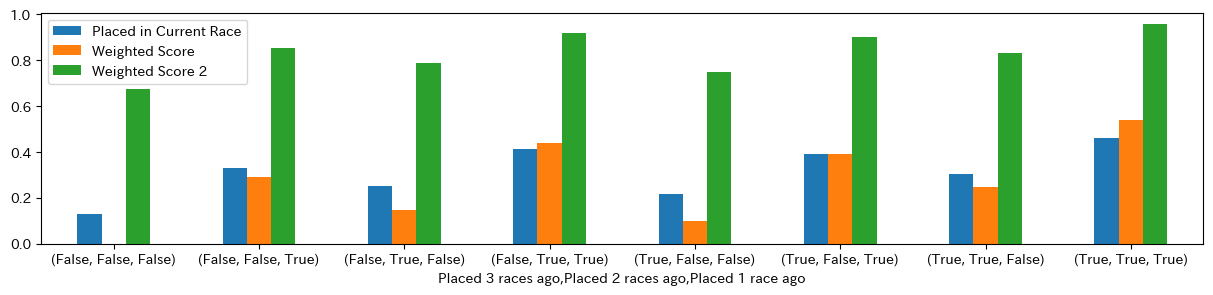

24/03/04 09:02:16 WARN HikariPool: HikariPool-1 - Thread starvation or clock leap detected (housekeeper delta=1m19s575ms).
24/03/04 09:02:16 WARN HikariPool: HikariPool-2 - Thread starvation or clock leap detected (housekeeper delta=1m19s572ms).
24/03/04 09:03:44 WARN HikariPool: HikariPool-1 - Thread starvation or clock leap detected (housekeeper delta=1m27s373ms).
24/03/04 09:03:44 WARN HikariPool: HikariPool-2 - Thread starvation or clock leap detected (housekeeper delta=1m27s373ms).
24/03/04 09:06:50 WARN HikariPool: HikariPool-1 - Thread starvation or clock leap detected (housekeeper delta=2m35s983ms).
24/03/04 09:06:50 WARN HikariPool: HikariPool-2 - Thread starvation or clock leap detected (housekeeper delta=2m35s983ms).
24/03/04 09:22:17 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 906606 ms exceeds timeout 120000 ms
24/03/04 09:22:17 WARN SparkContext: Killing executors is not supported by current scheduler.
24/03/04 09:22:20 WARN HikariPool: Hik

In [25]:
 df = data[[
    "meta_レースキー",
    "meta_着順",
    "num_一走前着順",
    "num_二走前着順",
    "num_三走前着順",
    "num_トップ3完走",
    "num_レース数",
    "num_頭数",
    "num_1走前頭数",
    "num_2走前頭数",
    "num_3走前頭数",
]].copy()

df = df.assign(
   Current_Place_Norm=(df["meta_着順"] - 1) / (df["num_頭数"] - 1),
   Last1_Place_Norm=(df["num_一走前着順"] - 1) / (df["num_1走前頭数"] - 1),
   Last2_Place_Norm=(df["num_二走前着順"] - 1) / (df["num_2走前頭数"] - 1),
   Last3_Place_Norm=(df["num_三走前着順"] - 1) / (df["num_3走前頭数"] - 1),
)

# weights = {"num_一走前着順": 0.30205828, "num_二走前着順": 0.16639774, "num_三走前着順": 0.12557666}
weights = {"num_一走前着順": 0.2927557, "num_二走前着順": 0.14651419, "num_三走前着順": 0.10043724}
print(f"Weights (determined with linear regression): {weights}")


def calculate_placed(score):
    return 1 if score <= 3 else 0


for race in weights.keys():
    df[f"{race}_placed"] = df[race].apply(calculate_placed)

df["Weighted Score"] = sum(df[f"{race}_placed"] * weight for race, weight in weights.items())

df["Weighted Score 2"] = 1 - sum((
   df["Last1_Place_Norm"] * weights["num_一走前着順"],
    df["Last2_Place_Norm"] * weights["num_二走前着順"],
    df["Last3_Place_Norm"] * weights["num_三走前着順"],
))

df["Placed in Current Race"] = df["meta_着順"] <= 3
df["Placed 1 race ago"] = df["num_一走前着順"] <= 3
df["Placed 2 races ago"] = df["num_二走前着順"] <= 3
df["Placed 3 races ago"] = df["num_三走前着順"] <= 3

# Group by the "placed" status in past races and calculate the percentage of placing in the current race
grouped = df.groupby(
    ["Placed 3 races ago", "Placed 2 races ago", "Placed 1 race ago"]
)

# Calculate the percentage for each group
result = grouped[["Placed in Current Race", "Weighted Score", "Weighted Score 2"]].mean() * 100
result = result.reset_index()

grouped[["Placed in Current Race", "Weighted Score", "Weighted Score 2"]].mean().plot(
    kind="bar", figsize=(15, 3), rot=0
)

result

In [24]:
df[["Weighted Score", "Placed in Current Race", "Weighted Score 2"]].assign(
    Current_Percentile=df.groupby("meta_レースキー")["meta_着順"].transform(
        lambda x: x.rank(pct=True)
    )
).corr()

,Weighted Score,Placed in Current Race,Weighted Score 2,Current_Percentile
Weighted Score,1.000000,0.259174,0.666663,-0.293687
Placed in Current Race,0.259174,1.000000,0.274771,-0.692412
Weighted Score 2,0.666663,0.274771,1.000000,-0.312478
Current_Percentile,-0.293687,-0.692412,-0.312478,1.000000


Let's use Linear Regression to see if we can optimize the weights.

In [18]:
df = data[['meta_レースキー', 'meta_着順', 'num_一走前着順', 'num_二走前着順', 'num_三走前着順',
"num_頭数",
"num_1走前頭数",
"num_2走前頭数",
"num_3走前頭数",
]].copy().rename(
    columns={
        "meta_レースキー": "RaceID",  # Assuming this is the unique identifier for
        'meta_着順': 'Current_Place',
        'num_一走前着順': 'Last1_Place',
        'num_二走前着順': 'Last2_Place',
        'num_三走前着順': 'Last3_Place',
    }
)

# df['Current_Percentile'] = df.groupby('RaceID')['Current_Place'].transform(lambda x: x.rank(pct=True))
# df['Last1_Percentile'] = df.groupby('RaceID')['Last1_Place'].transform(lambda x: x.rank(pct=True))
# df['Last2_Percentile'] = df.groupby('RaceID')['Last2_Place'].transform(lambda x: x.rank(pct=True))
# df['Last3_Percentile'] = df.groupby('RaceID')['Last3_Place'].transform(lambda x: x.rank(pct=True))

df = df.assign(
   Current_Place_Norm=(df["Current_Place"] - 1) / (df["num_頭数"] - 1),
   Last1_Place_Norm=(df["Last1_Place"] - 1) / (df["num_1走前頭数"] - 1),
   Last2_Place_Norm=(df["Last2_Place"] - 1) / (df["num_2走前頭数"] - 1),
   Last3_Place_Norm=(df["Last3_Place"] - 1) / (df["num_3走前頭数"] - 1),
)

# Assuming 'df' has been updated to include 'Last*_Percentile' columns
X = df[['Last1_Place_Norm', 'Last2_Place_Norm', 'Last3_Place_Norm']]
y = df['Current_Place_Norm']  # Assuming you've also calculated the percentile rank for the current race

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Retrieve the coefficients (weights)
optimal_weights = model.coef_

print("Optimal Weights for Percentile Ranks:", optimal_weights)

Optimal Weights for Percentile Ranks: [0.2927557  0.14651419 0.10043724]


# Hypothesis: Horses that placed well and have rested for fewer days are more likely to place well in the next race.

* True
* For horses that placed well in the previous race, there is a slight upward trend in probability of placing well as the number of days between races decreases.

**How to use:**
Use the inverse of the number of rest days during machine learning.

/var/folders/1p/ngsbv_gj3px52qmhqchv10j00000gn/T/ipykernel_82856/1968144509.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  place_well_percentage = df.groupby('num_休養日数')['Placed_Well'].mean().reset_index()


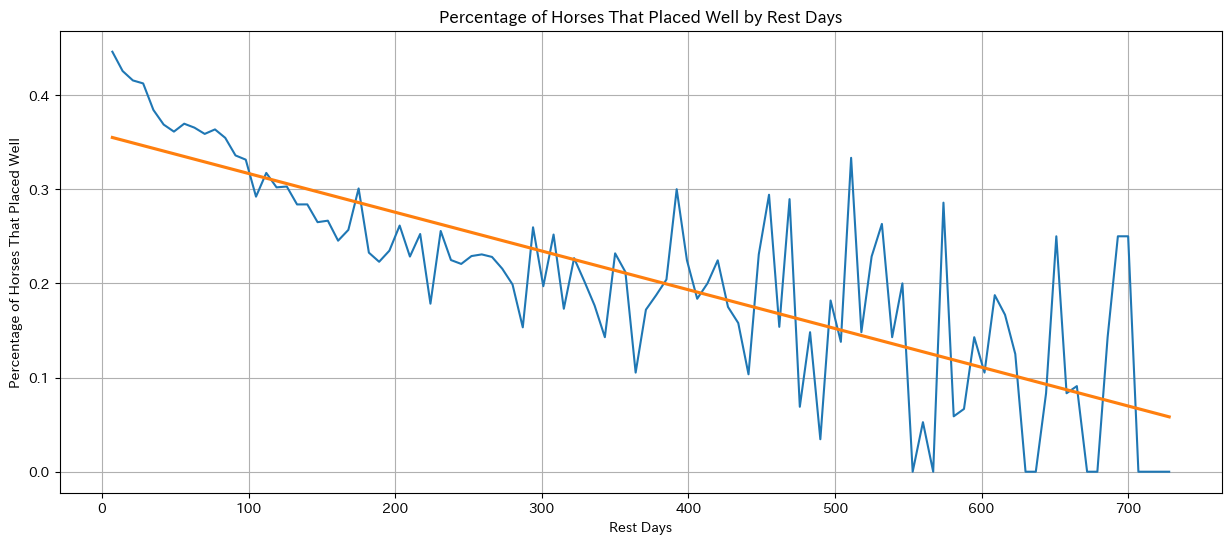

In [21]:
df = data[['meta_レースキー', 'num_入厩何日前', 'num_休養日数', 'meta_着順', 'num_一走前着順', 'num_二走前着順', 'num_三走前着順']].copy()

df = df[df["num_一走前着順"] <= 3]
df['num_休養日数'] = pd.cut(df['num_休養日数'], bins=[i for i  in range(0, 365 * 2, 7)], right=False)
df['num_休養日数'] = df['num_休養日数'].apply(lambda x: int(x.right))

# Calculate a binary indicator for placing well (1 if placed in top 3, else 0)
df['Placed_Well'] = (df['meta_着順'] <= 3).astype(int)

# Group by rest days and calculate the percentage of placing well
place_well_percentage = df.groupby('num_休養日数')['Placed_Well'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(data=place_well_percentage, x='num_休養日数', y='Placed_Well')
sns.regplot(data=place_well_percentage, x='num_休養日数', y='Placed_Well', order=1, ci=None, scatter=False)
plt.title('Percentage of Horses That Placed Well by Rest Days')
plt.xlabel('Rest Days')
plt.ylabel('Percentage of Horses That Placed Well')
plt.grid(True)
plt.show()


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


df = data[['meta_レースキー', 'num_入厩何日前', 'num_休養日数', 'meta_着順', 'num_一走前着順', 'num_二走前着順', 'num_三走前着順']].copy()

df['Placed_Well'] = (df['meta_着順'] <= 3).astype(int)

# Feature Engineering
df['Inverse_Rest_Days'] = 1 / df['num_休養日数']
df['Rest_Days_Squared'] = df['num_休養日数'] ** 2  # Optional, based on trend observation

# Prepare the dataset with the new feature(s)
X = df[['num_休養日数', 'Inverse_Rest_Days', 'Rest_Days_Squared', 'num_一走前着順', 'num_二走前着順', 'num_三走前着順']]
y = df['Placed_Well']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Initialize and train the model
model = RandomForestClassifier(random_state=random_state)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85    117347
           1       0.39      0.20      0.27     33114

    accuracy                           0.75    150461
   macro avg       0.60      0.56      0.56    150461
weighted avg       0.71      0.75      0.72    150461



In [29]:
model.feature_importances_

array([0.08733157, 0.08749546, 0.08654568, 0.276003  , 0.22950667,
       0.23311762])

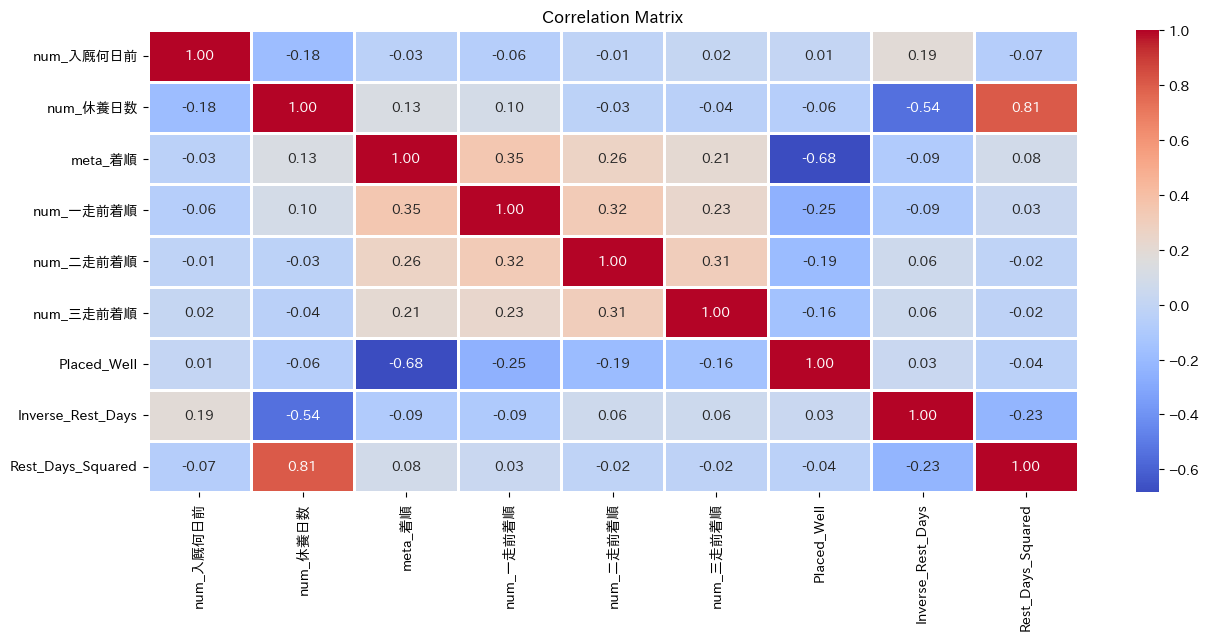

In [31]:
# get correlation
df = data[['num_入厩何日前', 'num_休養日数', 'meta_着順', 'num_一走前着順', 'num_二走前着順', 'num_三走前着順']].copy()

df['Placed_Well'] = (df['meta_着順'] <= 3).astype(int)

# Feature Engineering
df['Inverse_Rest_Days'] = 1 / df['num_休養日数']
df['Rest_Days_Squared'] = df['num_休養日数'] ** 2  # Optional, based on trend observation

# Calculate the correlation matrix
correlation = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title('Correlation Matrix')
plt.show()

# Hypothesis: Horses that placed in 2 of the past 3 races but lost once (and there was a good excuse for it) have a higher chance of placing than horses that didn't have an excuse.

Possible excuses:
* 不利 (>=1)
* 休み明け

Outcome:
* True
* Effect more pronounced as 不利 increases

```
Number of Horses in the Target Group: 9242
Percentage of Horses in the Target Group That Placed Well: 40.79%
Percentage of Horses Not in the Target Group That Placed Well: 21.84%
```

**How to use:** Create a flag feature for horses in the target group.

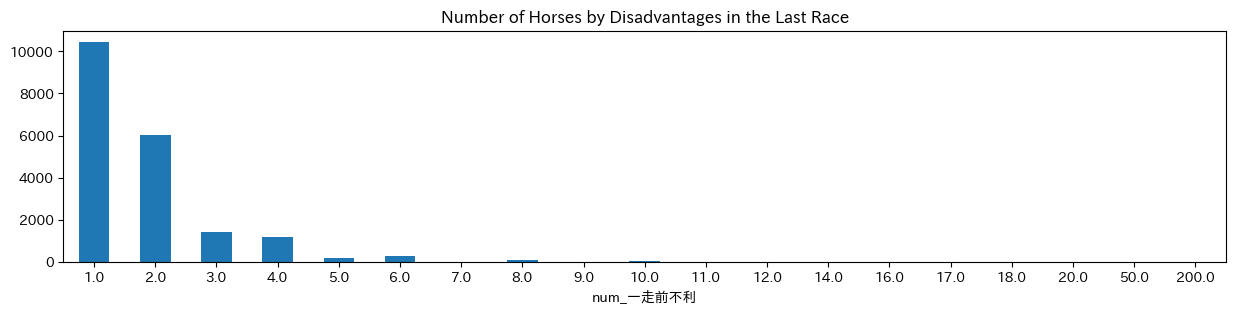

In [35]:
data[data["num_一走前不利"] > 0]["num_一走前不利"].value_counts().sort_index().plot(
    kind="bar",
    figsize=(15, 3),
    rot=0,
    title="Number of Horses by Disadvantages in the Last Race",
);

count    106643.000000
mean         31.756421
std          36.809440
min           9.000000
25%          21.000000
50%          25.000000
75%          32.000000
max        1423.000000
Name: num_入厩何日前, dtype: float64

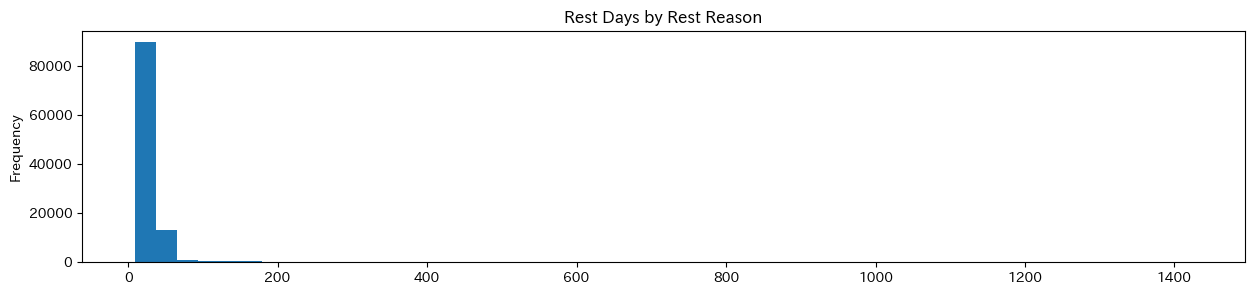

In [6]:
df = data[['meta_着順', 'num_一走前着順', 'num_二走前着順', 'num_三走前着順', 'num_休養日数', "num_入厩何日前", "cat_休養理由分類コード"]].copy()

df[~df["cat_休養理由分類コード"].isna()]["num_入厩何日前"].plot.hist(
    bins=50, figsize=(15, 3), title="Rest Days by Rest Reason"
);

df[~df["cat_休養理由分類コード"].isna()]["num_入厩何日前"].describe()

In [45]:
df = data[['meta_着順', 'num_一走前着順', 'num_二走前着順', 'num_三走前着順', 'num_一走前不利', 'num_二走前不利', 'num_三走前不利', 'cat_3走前休養理由分類コード']].copy().rename(
    columns={
        'num_一走前着順': 'num_1走前着順',
        'num_二走前着順': 'num_2走前着順',
        'num_三走前着順': 'num_3走前着順',
        'num_一走前不利': 'num_1走前不利',
        'num_二走前不利': 'num_2走前不利',
        'num_三走前不利': 'num_3走前不利',
    }
)

# Define placing well as finishing in the top 3
df['Placed_Well'] = df['meta_着順'].apply(lambda x: 1 if x <= 3 else 0)

# Initialize an 'Excuse' column to False
df['Excuse'] = False

# Check each of the last three races
for i in range(1, 4):
    # Identify if the horse had a significant excuse in a race it did not place well
    df.loc[(df[f'num_{i}走前着順'] > 3) & (df[f'num_{i}走前不利'] >= 1), 'Excuse'] = True

# If cat_3走前休養理由分類コード is in ['01', '02', '03', '04', '05', '06', '07'], and num_3走前着順 > 3, then the horse had a excuse
df.loc[(df['cat_3走前休養理由分類コード'].isin(["01", "02", "03", "04", "05", "06", "07"])) & (df['num_3走前着順'] > 3), 'Excuse'] = True

# Now, filter horses that placed in 2 of the past 3 races but had a significant excuse in the race they lost
df['Placed_Well_2_of_3'] = (df[['num_1走前着順', 'num_2走前着順', 'num_3走前着順']] <= 3).sum(axis=1) == 2
df['Target_Group'] = df['Placed_Well_2_of_3'] & df['Excuse']

# You can now analyze the 'Target_Group' to compare their performance against other groups
percent_a = df[df['Target_Group']]['Placed_Well'].mean() * 100
percent_b = df[~df['Target_Group']]['Placed_Well'].mean() * 100

print(f"Number of Horses in the Target Group: {df['Target_Group'].sum()}")
print(f"Percentage of Horses in the Target Group That Placed Well: {percent_a:.2f}%")
print(f"Percentage of Horses Not in the Target Group That Placed Well: {percent_b:.2f}%")

Number of Horses in the Target Group: 9242
Percentage of Horses in the Target Group That Placed Well: 40.79%
Percentage of Horses Not in the Target Group That Placed Well: 21.84%


# 仮説：同一トラック（芝/ダート）の複勝率が条件戦で55%以上、重賞レースで75%以上を超えていて、10走以上の成績がある馬は、堅実な馬であるため、次のレースでも複勝率が高い。

This is hard to calculate. Try doing it in SQL.

In [71]:
"I give up"

'I give up'

# 仮説：近10走の複勝率が8割以上の馬は、的中率が高い。

* True, but not only 2337 horses over 20 years have this condition..
* Lowering the number of required races from 10 to 5 increases the number of horses to 11,000 and the percentage of horses in the target group that placed actually increases to 48.16%.

```
Number of Horses in the Target Group: 2337
Percentage of Horses in the Target Group That Placed Well: 47.75%
Percentage of Horses Not in the Target Group That Placed Well: 22.00%
```

**How to use:**
* Create a flag feature for horses in the target group.
* Add a feature for the 複勝率 for the past 10 races (check which is more important through features importance).

In [82]:
df = data[["meta_着順", "num_レース数", "num_トップ3完走率"]].copy()

group_a = df[(df["num_レース数"] >= 5) & (df["num_トップ3完走率"] >= 0.8)]
group_b = df[~df.index.isin(group_a.index)]

percent_a = (group_a["meta_着順"] <= 3).sum() / group_a.shape[0]
percent_b = (group_b["meta_着順"] <= 3).sum() / group_b.shape[0]

print(f"Number of Horses in the Target Group: {group_a.shape[0]}")
print(f"Percentage of Horses in the Target Group That Placed Well: {percent_a * 100:.2f}%")
print(f"Percentage of Horses Not in the Target Group That Placed Well: {percent_b * 100:.2f}%")

Number of Horses in the Target Group: 11122
Percentage of Horses in the Target Group That Placed Well: 48.16%
Percentage of Horses Not in the Target Group That Placed Well: 21.68%


# Train model

In [ ]:
data_ = pd.DataFrame(index=data.index)

# Meta columns
data_["レースキー"] = data["meta_レースキー"]
data_["発走日時"] = data["meta_発走日時"]
data_["馬番"] = data["meta_馬番"]
data_["着順"] = data["meta_着順"]
data_["複勝的中"] = data["meta_複勝的中"]
data_["複勝オッズ"] = data["num_事前複勝オッズ"]
data_["複勝払戻金"] = data["meta_複勝払戻金"]
data_["血統登録番号"] = data["meta_int_race_horses_血統登録番号"]


# Features
def calculate_placed(score):
    return 1 if score <= 3 else 0


weights = {
    "num_一走前着順": 0.30205828,
    "num_二走前着順": 0.16639774,
    "num_三走前着順": 0.12557666,
}
for race in weights.keys():
    data[f"{race}_placed"] = data[race].apply(calculate_placed)


data["Weighted Score"] = sum(data[f"{race}_placed"] * weight for race, weight in weights.items())

# Filtering
# data_ = data_[data_["発走日時"].dt.year >= 2003]


# fmt: off
categories = [
    ["距離", [1000, 1150, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 3000, 3200, 3400, 3600]],
    ["枠番", [1, 2, 3, 4, 5, 6, 7, 8]],
]
category_keys = [category[0] for category in categories] if categories else []
category_values = [category[1] for category in categories] if categories else []
num_cols = [
    "前走距離差",
    "年齢",
    "馬体重増減",
    "負担重量",
    "頭数",
    "情報指数",
    "騎手指数",
    "総合情報◎",
    "競争相手平均総合指数差",
]
num_null_cols = [
    "馬体重",  # 95% of 馬体重 null values are where 異常区分 != 0
    "競争相手平均入厩何日前"
]
cat_cols = [
    "トラック種別"
]
meta_cols = ["レースキー", "複勝的中", "複勝払戻金"]
all_cols = category_keys + num_cols + num_null_cols + cat_cols + meta_cols
# fmt: on

# preprocessor = ColumnTransformer(
#     transformers=[
#         # fmt: off
#         ("ord", OrdinalEncoder(categories=category_values), category_keys),
#         ("num", StandardScaler(), num_cols),
#         ("num_null", Pipeline(steps=[("imputer", SimpleImputer()), ("scaler", StandardScaler())]), num_null_cols),
#         ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
#         ("meta", "passthrough", meta_cols)
#         # fmt: on
#     ],
#     remainder="drop",
# )

# pipeline = ImblearnPipeline(
#     steps=[
#         ("preprocessor", preprocessor),
#         ("smote", SMOTE(random_state=random_state)),
#         ("classifier", LGBMClassifier(random_state=random_state)),
#     ]
# )